**<h1>Damage Localization Model Fine-Tuning</h1>**

# Import libraries

In [1]:
import os
import cv2
import yaml
import shutil
import random
import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from torchvision import transforms
from ultralytics import YOLO

import warnings
warnings.filterwarnings(action='ignore')

# Define configurations

In [2]:
DATASET_ROOT = "../../data/YOLO_DATASET_SEVERITY"
CONFIG = {
    'IMAGES_ROOT' : Path(DATASET_ROOT, 'images'),
    'LABELS_ROOT' : Path(DATASET_ROOT, 'labels'),
    'DATA_SEVERITY_YAML' : Path(DATASET_ROOT, 'data_severity.yaml'),
    'EPS': 1e-8,
    'FINAL_MODEL_DIR': Path("../../models/final_model/damage_severity_model").resolve(),

    'OUTPUT_DIR' : Path("../../models/runs/damage_models").resolve(),
    'DEVICE' : "cuda" if torch.cuda.is_available() else 'cpu',

    'EPOCH' : 50,
    'BATCH_SIZE' : 32,
}

with open(CONFIG['DATA_SEVERITY_YAML']) as f:
    data_yaml = yaml.safe_load(f)
    CONFIG['SEVERITY_CLASSES'] = data_yaml['names']

if CONFIG['DEVICE'] == 'cuda':
    print(f"Using GPU")
else:
    print(f"Using CPU")

Using GPU


In [3]:
img_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ColorJitter(brightness=0.15, contrast=0.2, saturation=0.1, hue=0.02)
])

# Define dataset for EDA

In [4]:
class YoloDataset(Dataset):
    def __init__(self, image_dir: str, label_dir: str, transform: transforms = None):
        self.__image_dir = image_dir
        self.__label_dir = label_dir
        self.__transform = transform
        self.__images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.__images)

    def __getitem__(self, index):
        img_name = self.__images[index]
        img_path = os.path.join(self.__image_dir, img_name)
        label_path = os.path.join(self.__label_dir, img_name.replace(".jpg", '.txt'))

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.__transform:
            img = self.__transform(torch.from_numpy(img).permute(2, 0, 1)).permute(1, 2, 0).numpy()

        boxes = []
        if os.path.exists(label_path):
            with open(label_path) as f:
                for line in f:
                    boxes.append(list(map(float, line.split())))
        else:
            print(f"{label_path} does not exist")

        return img, boxes, img_name

# Define some helper function

In [5]:
def draw_bbox(img, boxes, cls_names):
    h, w = img.shape[:2]

    # boxes may be:
    # - list
    # - tensor
    # - nested (batch)
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.cpu().numpy()

    for box in boxes:
        # box = [tensor([cls]), tensor([xc]), ...] OR numpy array
        box = [float(v.item() if hasattr(v, "item") else v) for v in box]

        cls, xc, yc, bw, bh = box
        cls = int(cls)

        x1 = int((xc - bw / 2) * w)
        y1 = int((yc - bh / 2) * h)
        x2 = int((xc + bw / 2) * w)
        y2 = int((yc + bh / 2) * h)

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            img,
            cls_names[cls],
            (x1, max(0, y1 - 8)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (0, 255, 0),
            2,
        )

    return img

# EDA

In [6]:
eda_dataset = YoloDataset(CONFIG['IMAGES_ROOT'] / "train", CONFIG['LABELS_ROOT'] / "train", transform=img_transform)

loader = DataLoader(eda_dataset, batch_size=1, shuffle=True)

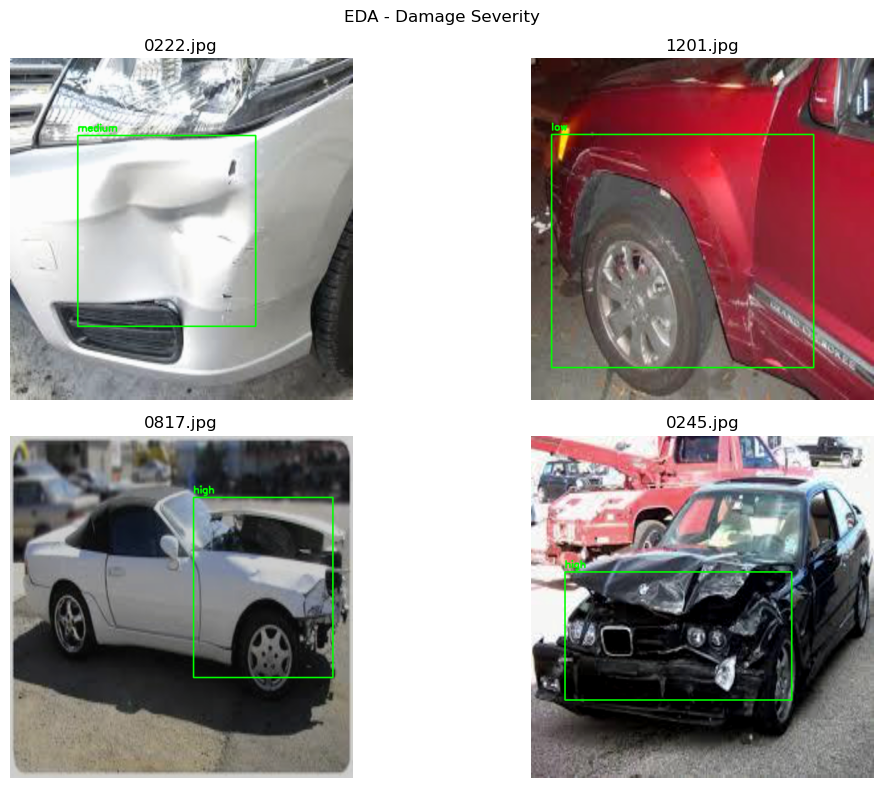

In [7]:
plt.figure(figsize=(12, 8))

for i, (img, boxes, name) in enumerate(loader):
    if i == 4:
        break

    # take first image as img is a batch
    img = img[0]

    # Ensure CHW → HWC exactly once
    if isinstance(img, torch.Tensor):
        if img.ndim == 3 and img.shape[0] == 3:
            img = img.permute(1, 2, 0)  # CHW → HWC
        img = img.cpu().numpy()

    # Convert to uint8
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)

    img = np.ascontiguousarray(img)

    # Draw bounding boxes
    img = draw_bbox(img, boxes, CONFIG["SEVERITY_CLASSES"])

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(name[0])
    plt.axis("off")

plt.suptitle("EDA - Damage Severity")
plt.tight_layout()
plt.show()


# Training model YOLO Severity

In [8]:
sev_model = YOLO("yolov8n.pt")

sev_model.train(
    data = str(CONFIG['DATA_SEVERITY_YAML']),
    epochs = CONFIG['EPOCH'],
    imgsz = 640,
    batch = CONFIG['BATCH_SIZE'],
    device = CONFIG['DEVICE'],
    project = CONFIG['OUTPUT_DIR'],
    name = 'yolov8_damage_severity_model',

    degrees = 0,
    translate = 0,
    scale = 0,
    shear = 0,
    perspective = 0,
    fliplr = 0,
    flipud = 0,

    hsv_h = 0.015,
    hsv_s = 0.3,
    hsv_v = 0.2,
    mosaic = 0,
    mixup = 0
)

Ultralytics 8.4.0  Python-3.11.14 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 16311MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=..\..\data\YOLO_DATASET_SEVERITY\data_severity.yaml, degrees=0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0, flipud=0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.3, hsv_v=0.2, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0, multi_scale=0.0, name=yolov8_damage_severity_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mas

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002370189D590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          

# Evaluation

In [9]:
result_sev_model = f"../../models/runs/damage_models/yolov8_damage_severity_model/results.csv"

if (not os.path.exists(result_sev_model)):
    raise FileNotFoundError(f"results.csv not found!")

In [10]:
sev_df = pd.read_csv(result_sev_model)

## Evaluate severity model

In [11]:
epochs = sev_df.index + 1

train_box = sev_df['train/box_loss']
train_cls = sev_df['train/cls_loss']
train_dfl = sev_df['train/dfl_loss']

val_box = sev_df['val/box_loss']
val_cls = sev_df['val/cls_loss']
val_dfl = sev_df['val/dfl_loss']

train_total = train_box + train_cls + train_dfl
val_total = val_box + val_cls + val_dfl

precision = sev_df['metrics/precision(B)']
recall = sev_df['metrics/recall(B)']
map50 = sev_df['metrics/mAP50(B)']
map5095 = sev_df['metrics/mAP50-95(B)']

print("\nFinal Epoch Metrics:")
print(sev_df.tail(1)[[
    "train/box_loss", "train/cls_loss", "train/dfl_loss",
    "val/box_loss", "val/cls_loss", "val/dfl_loss",
    "metrics/precision(B)", "metrics/recall(B)",
    "metrics/mAP50(B)", "metrics/mAP50-95(B)"
]])


Final Epoch Metrics:
    train/box_loss  train/cls_loss  train/dfl_loss  val/box_loss  \
49         0.07628         0.38453         0.75925       2.04783   

    val/cls_loss  val/dfl_loss  metrics/precision(B)  metrics/recall(B)  \
49       2.75525       2.64942               0.33682            0.20974   

    metrics/mAP50(B)  metrics/mAP50-95(B)  
49           0.23404              0.08269  


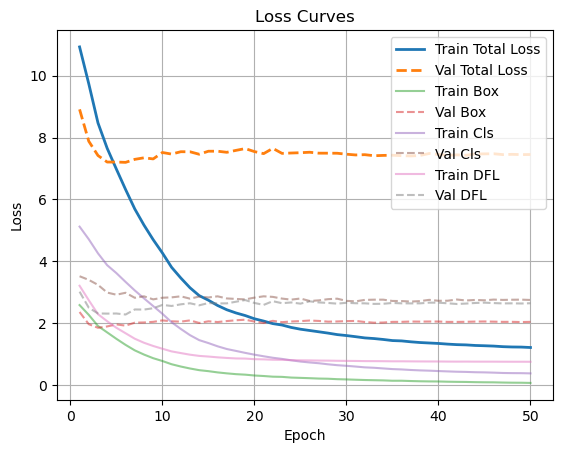

In [12]:
plt.plot(epochs, train_total, label="Train Total Loss", linewidth=2)
plt.plot(epochs, val_total, label="Val Total Loss", linewidth=2, linestyle="--")
plt.plot(epochs, train_box, label="Train Box", alpha=0.5)
plt.plot(epochs, val_box, label="Val Box", alpha=0.5, linestyle="--")
plt.plot(epochs, train_cls, label="Train Cls", alpha=0.5)
plt.plot(epochs, val_cls, label="Val Cls", alpha=0.5, linestyle="--")
plt.plot(epochs, train_dfl, label="Train DFL", alpha=0.5)
plt.plot(epochs, val_dfl, label="Val DFL", alpha=0.5, linestyle="--")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

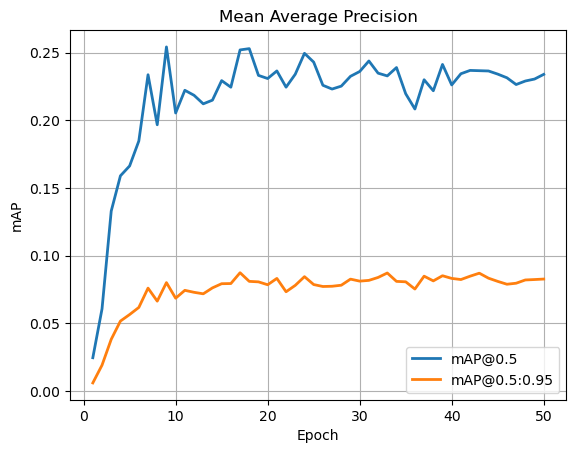

In [13]:
plt.plot(epochs, map50, label="mAP@0.5", linewidth=2)
plt.plot(epochs, map5095, label="mAP@0.5:0.95", linewidth=2)
plt.title("Mean Average Precision")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.legend()
plt.grid(True)

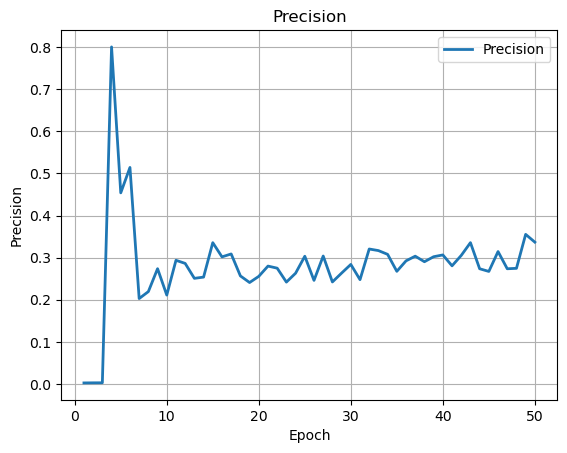

In [14]:
plt.plot(epochs, precision, label="Precision", linewidth=2)
plt.title("Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)

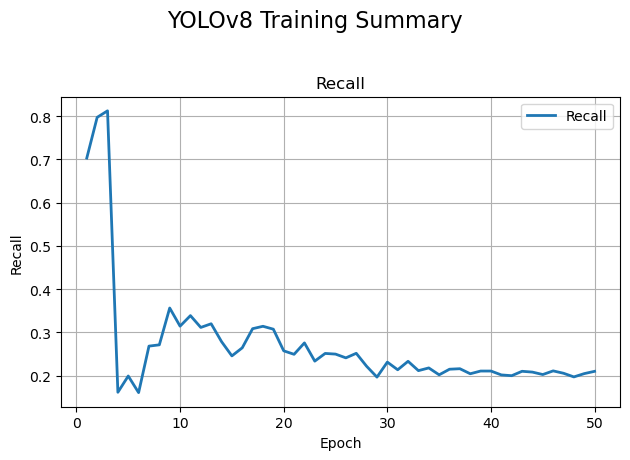

In [15]:
plt.plot(epochs, recall, label="Recall", linewidth=2)
plt.title("Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)

plt.suptitle("YOLOv8 Training Summary", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [16]:
metrics = sev_model.val(
    data=str(CONFIG['DATA_SEVERITY_YAML']),
    split="val"
)

# Per-class AP@0.5:0.95
per_class_map = metrics.box.maps  # numpy array

for cls, ap in zip(CONFIG['SEVERITY_CLASSES'], per_class_map):
    print(f"{cls}: mAP50-95 = {ap:.4f}")

Ultralytics 8.4.0  Python-3.11.14 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 16311MiB)
Model summary (fused): 73 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 229.651.4 MB/s, size: 11.7 KB)
val: Scanning C:\Users\reube\Documents\PERSONAL_PROJECTS\CAR DAMAGE CLASSIFICATION AND CAPTIONING\data\YOLO_DATASET_SEVERITY\labels\validation.cache... 242 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 242/242  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 10.7it/s 1.5s0.2s
                   all        242        242      0.295      0.292      0.244     0.0856
                   low         65         65      0.156      0.154     0.0933     0.0304
                medium         53         53      0.173      0.189      0.105     0.0305
                  high        124        124      0.556      0.532      0.534      0.196
Speed: 1.1ms preprocess, 2.2ms in

(np.float64(-0.5), np.float64(2399.5), np.float64(1199.5), np.float64(-0.5))

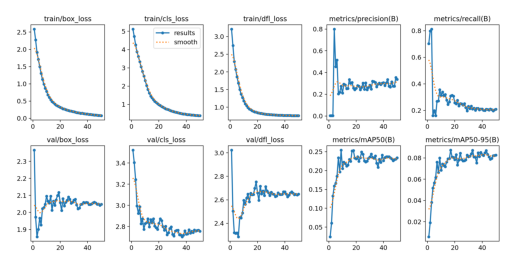

In [17]:
img = Image.open("../../models/runs/damage_models/yolov8_damage_severity_model/results.png")
plt.imshow(img)
plt.axis("off")

# Testing Phase

In [18]:
sev_best = YOLO(f"{CONFIG['OUTPUT_DIR']}/yolov8_damage_severity_model/weights/best.pt", verbose=False)
sev_best.eval()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [25]:
CONFIG['TEST_DIR'] = CONFIG['IMAGES_ROOT'] / "test"
samples = random.sample(list(CONFIG['TEST_DIR'].iterdir()), min(4, len(list(CONFIG['TEST_DIR'].iterdir()))))

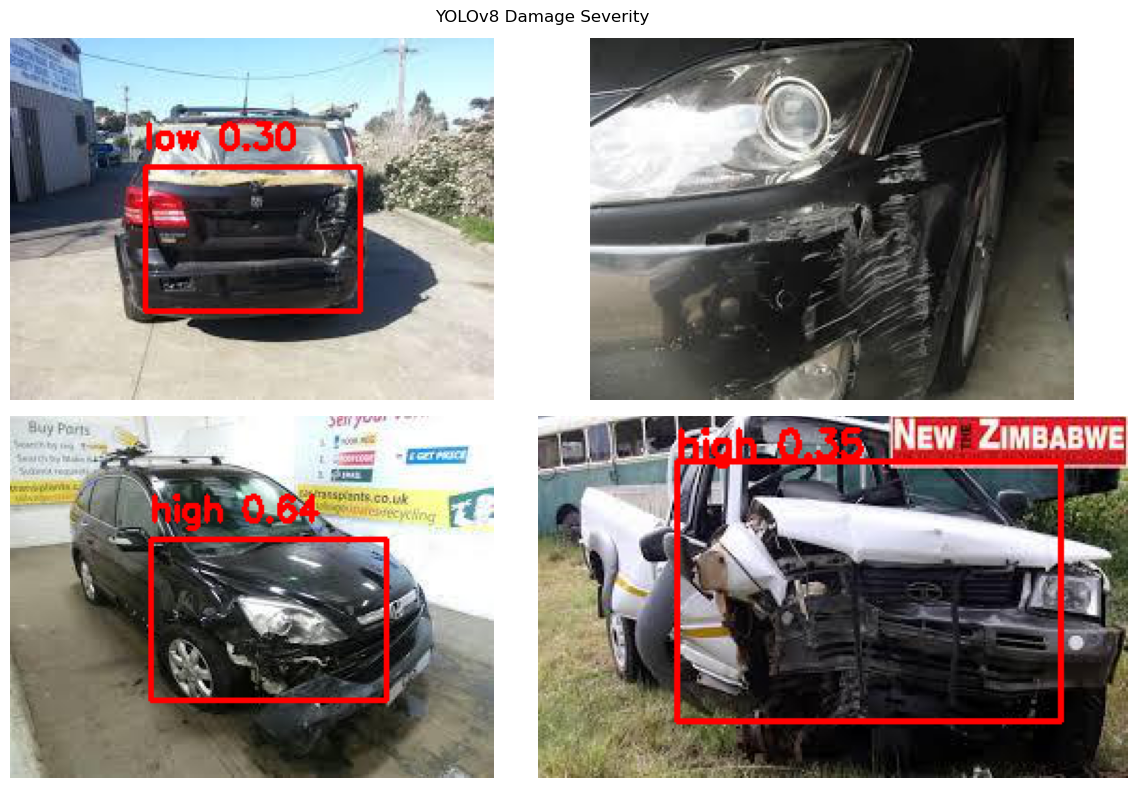

In [26]:
plt.figure(figsize=(12, 8))
for i, img_path in enumerate(samples):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    sev_res = sev_best.predict(str(img_path), conf=0.25, verbose=False)[0]

    for box in sev_res.boxes:
        cls = int(box.cls.item())
        conf = float(box.conf.item())

        x1, y1, x2, y2 = map(int, box.xyxy[0])

        label = f"{CONFIG['SEVERITY_CLASSES'][cls]} {conf:.2f}"

        # Draw box
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Draw label
        cv2.putText(
            img,
            label,
            (x1, max(y1 - 10, 20)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2
        )
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.suptitle("YOLOv8 Damage Severity")
plt.tight_layout()
plt.show()

In [27]:
best_pt = (
    CONFIG['OUTPUT_DIR']
    / "yolov8_damage_severity_model"
    / "weights"
    / "best.pt"
)

dst = CONFIG['FINAL_MODEL_DIR'] / "yolov8_damage_severity_best.pt"

shutil.copy(best_pt, dst)

print(f"Saved best model to: {dst}")

Saved best model to: C:\Users\reube\Documents\PERSONAL_PROJECTS\CAR DAMAGE CLASSIFICATION AND CAPTIONING\models\final_model\damage_severity_model\yolov8_damage_severity_best.pt
